# Simulation Environments (last updated 21.05.12)
- **CU with local dataset**
- **Local dataset**: Unbalanced (3 classes/local dataset), Non-i.i.d., non-overapped samples
- **Channel**: Pathloss + Rayleigh fading
- **Power allocation**: Water-filling like power allocation
- **Transmission type**: Analog Transmission with Compressed Sensing (AMP)

- CU and deivces have the same weight for the model update

In [1]:
!pip install PyWavelets
!pip install scikit-learn

In [2]:
import sys, os
sys.path.append('/workspace/shared/')

In [3]:
vp_path = os.path.abspath('vampyre-master/')
if not vp_path in sys.path:
    sys.path.append(vp_path)
import vampyre as vp

In [4]:
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(self.conv2(x))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

### Default Setup *(Do not modify)*

In [6]:
lr = 0.1   # 0.1
batch_local = 10   # Size of local minibatch
E = 3 #3  # Local training epoch
epoch_max = 200
D = sum( p.numel() for p in net.parameters() if p.requires_grad)   # Number of parameters in model, 582,026 

noise_pow_dBm = -80 #-50
P_dBm = 20  #20
gamma = 0.1  #0.1 Target received SNR

sparse_energy = 0.9   # Sparse signal to original energy ratio
undersampl_fr = 0.1

# Measurement matrix generation
B = 1024    # Number of sub-channels

cell_radius = 150
density = 250/(np.pi*500**2) # 250 devices within the circle of radius 500
pathloss_exponent = 4

num_classes = 3   # Number of classes in local dataset
samples_avg_local = 200   # Average number of local samples
samples_CU = samples_avg_local   # Number of samples at CU

regul_coeff = 10e-5   # L2 regularization parameter for avoiding overfitting
#init_E = E   # Pre-training epoch

### Variations in Setup *(Adjustable)*

In [7]:
P_dBm = 0

### Load Simulation Setups

In [8]:
PATH_DEPLOYMENT = '../shared/simulation_setups/Deployment_within_550.npy'
PATH_TRAIN_DATASET = '../shared/simulation_setups/train_dataset.pth'
PATH_LOCAL_DATASET = '../shared/simulation_setups/localdataset_within_550.npy'

dev_deployment = np.load(PATH_DEPLOYMENT)        # Deployment of devices within 550 meters
trainset = torch.load(PATH_TRAIN_DATASET)         # Load training data and labels
x, y = trainset.values()
idx_localDB = np.load(PATH_LOCAL_DATASET, allow_pickle=True)        # Classified data indices

### Other System Parameters *(Do not modify)*

In [9]:
noise_pow = 10**(noise_pow_dBm/10)
P = 10**(P_dBm/10)
Bt = int(B/undersampl_fr)    # Number of delivering parameters in a single OFDM symbol transmission
N = int(np.ceil(D/Bt))   # Number of transmit OFDM symbols
A = np.random.normal(0, 1/np.sqrt(Bt), (B, Bt) )
dev_num = np.sum((np.linalg.norm(dev_deployment, axis=1)<cell_radius))   # Number of devices
samples_local = [ len(idx_localDB[i]) for i in range(dev_num)]     # Number of samples at devices
samples_global = samples_CU+np.sum(samples_local)
print('Number of devices: ', dev_num)
print('Numnber of global samples: ', samples_global)

dev_dist = np.linalg.norm(dev_deployment[:dev_num], axis=1)
pathloss = dev_dist**-pathloss_exponent
print('Link distances: ', dev_dist[0:5])
print('Pathloss: ', pathloss[0:5])

permute_seq = np.random.permutation(N*Bt)    # Shuffling rule
permute_seq_inv = np.argsort(permute_seq)    # Inverse shuffling rule

Number of devices:  25
Numnber of global samples:  5278
Link distances:  [22.83855181 34.12266929 41.28552959 42.75910894 59.44096671]
Pathloss:  [3.67557892e-06 7.37612065e-07 3.44198173e-07 2.99147525e-07
 8.01044318e-08]


In [10]:
########### Data classification ##############
idx = []   # Empty list
for i in range(10):
    tmp = list((y==i).nonzero()[0])
    idx.append(tmp)
    
############ CU dataset ############
CU_x = torch.zeros(samples_CU,1, 28, 28)
CU_y = np.zeros(samples_CU, dtype=int)
CU_dataset = []
for i in range(10):
    CU_dataset += idx[i][:int(samples_CU/10)]
random.shuffle(CU_dataset)
    
for i, idx_CU in enumerate(CU_dataset):
    CU_x[i], CU_y[i] = x[idx_CU], y[idx_CU]

################### Test dataset ##################
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
testset = torchvision.datasets.MNIST(root='../shared/MNIST_dataset/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False, num_workers=3)

classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

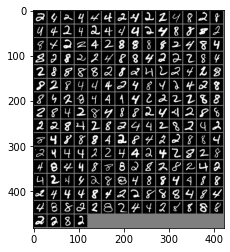

2, 4, 2, 4, 4, 4, 2, 4, 2, 2, 4, 8, 2, 8,


In [11]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images = x[idx_localDB[0]]
labels = y[idx_localDB[0]]

# show images
first_row = int(np.sqrt(samples_local[0]))
imshow(torchvision.utils.make_grid(images, nrow=first_row))
# print labels
print(' '.join('%d,' % classes[labels[j]] for j in range(int(first_row))))

In [12]:
def model_localupdate(inputs, labels, net_org, E, batch_local, samples_local, lr):
    criterion = nn.CrossEntropyLoss()
    running_loss_local = 0.0
    acc_local = 0.0
    net_local = copy.deepcopy(net_org)   # deep copy of the network
    for _ in range(E):   # Local training epoch
        for b in range(int(np.ceil(samples_local/batch_local))):
            
            L2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in net_local.parameters():
                L2_reg = L2_reg + torch.norm(param, 2)
            
            start_idx = b*batch_local
            end_idx = b*batch_local+np.min([batch_local, samples_local-b*batch_local])
            outputs = net_local(inputs[start_idx:end_idx])
            loss = criterion(outputs, labels[start_idx:end_idx]) + regul_coeff*L2_reg   # 10e-4 L2-Regularization to prevent overfitting 
            net_local.zero_grad()
            loss.backward()
            
            if math.isnan(loss.item()): # Catch error
                print("outputs", outputs)
                print("inputs", inputs[start_idx:end_idx])
                w_sum = 0
                for i in net_local.parameters():
                    w_sum+=torch.sum(i)
                print('Sum of parameters: ', w_sum.item())
                ErrorOccur = input("Nan appears")
            
            with torch.no_grad():
                running_loss_local += loss.item()/(samples_local/batch_local)/E
                _, predicted = torch.max(outputs.data, 1)
                acc_local += (predicted == labels[start_idx:end_idx]).sum().item()
                for param_local in net_local.parameters():
                    param_local -= lr*param_local.grad
                    if math.isnan(torch.sum(param_local).item()):   # Catch error
                        print(param_local)
                        ErrorOccur = input("Nan appears")
                        
    return net_local, running_loss_local, acc_local          

In [13]:
def power_allocation(gamma, noise_pow, P, N, B, delta, h_pow, rho, samples_local, samples_global):
    delta_pow_2d = (delta**2).reshape((N, B))   # (N, B)
            
    g = (1/h_pow).reshape((N,B))    
    w = samples_local/samples_global
    u = (gamma*noise_pow/rho) * g * w**2   # (N, B)
    c_init = np.max(delta**2)/(np.min(u))
            
    v = 1.0*delta_pow_2d   #(N,B)
    WF_idx = np.nonzero(1.0*(np.sum(u*delta_pow_2d, axis=1) > P))[0]   # (N, ) Sub-carriers for waterfilling 
            
    for idx in WF_idx:
        c_min = 0
        while np.sum(u[idx]*np.maximum(delta_pow_2d[idx]-c_init*u[idx],0))>P:
            c_init *=2
        c_max = c_init
                                    
        while (c_max - c_min)>c_init*10**-10:
            c_mid = (c_min+c_max)/2
            v_mid = np.maximum(delta_pow_2d[idx]-c_mid*u[idx], 0)
            if np.sum(v_mid*u[idx])>P:
                c_min = c_mid
            else:
                c_max = c_mid
        v[idx] = v_mid
                
    P_alloc = (u*v).reshape(-1)   # (N*B, )

    return P_alloc 

In [14]:
def sparsify(paramer_stack, N, Bt, energy_frac, sp_max = []):
    if len(sp_max)==0: sp_max = Bt
    syms = paramer_stack.reshape((N, Bt))
    eps = 10**(-10)   # Prevent dividing by zero
    pows = syms**2    # (N, Bt)
    desc_ordered_pows = np.flip(np.sort(pows, axis=1), axis=1)    # (N, Bt)
    pow_sum = np.sum(syms**2, axis=1).reshape((N,1))
    sp_tmp = np.sum(1.0*(np.cumsum(desc_ordered_pows/(pow_sum+eps), axis=1)<energy_frac), axis=1)    # N 
    sparsities =  np.minimum(np.maximum(sp_tmp, 1), sp_max)    # N
    threshold = np.take_along_axis(desc_ordered_pows, (sparsities.astype(int)).reshape((N,1)), axis=1)   # (N, 1)
    syms_sp = syms*(1.0*(syms**2>=threshold))    # Sum-power of significant entries account for 'energy_frac' of symbol power
    return sparsities, syms_sp    # N , NxBt 

In [15]:
def decompression_AMP(N, B, Bt, Y, rho, gamma, noise_pow, nz_means, nz_vars, sparsities_CU, A):
    param_recover_1d = np.zeros(N*Bt)
    est0_off = vp.estim.DiscreteEst(0, 1, (Bt,))    
    for s in range(N):
        #Ym = np.sqrt(rho/(gamma*noise_pow))*Y[s:s+B]
        Ym = np.sqrt(rho/(gamma*noise_pow))*Y[s*B:s*B+B]
        est0_on = vp.estim.GaussEst(nz_means[s] , nz_vars[s], (Bt,))
        est_list = [est0_off, est0_on]
        pz0 = np.array([1-sparsities_CU[s]/Bt, sparsities_CU[s]/Bt])
        est0 = vp.estim.MixEst(est_list, w=pz0, name='Input')
        Aop = vp.trans.MatrixLT(A, (Bt,))
        est1 = vp.estim.GaussEst(Ym, rho/gamma , (B, ), name='Output')
        
        solver = vp.solver.Gamp(est0, est1, Aop, hist_list=['z0', 'zvar0'], nit=20)
        solver.solve()
        
        #param_recover_1d[s:s+Bt] = solver.z0
        param_recover_1d[s*Bt:s*Bt+Bt] = solver.z0
    return param_recover_1d    

In [16]:
net_diff = Net()
net_diff.to(device)   # Storing network update
train_acc_history = np.zeros(epoch_max)
update_rho_history = np.zeros(epoch_max)

#inputs, labels = CU_x.to(device), torch.tensor(CU_y, dtype=torch.long).to(device)
#net, _, _ = model_localupdate(inputs, labels, net, init_E, batch_local, samples_CU, lr)

for epoch in range(epoch_max):  # loop over the dataset multiple times 
       
    ##################### Wireless Channel ###########################
    H_pow = pathloss.reshape(dev_num, 1)*np.random.exponential(1, (dev_num, B*N))    # Channel power gains, dev_num x BN
    
    ############# Update at the central unit ###############
    with torch.no_grad():   # Reset update
        for param_diff in net_diff.parameters():
            param_diff = torch.zeros_like(param_diff)
    
    inputs, labels = CU_x.to(device), torch.tensor(CU_y, dtype=torch.long).to(device)
    net_CU, running_loss_CU, acc_CU = model_localupdate(inputs, labels, net, E, batch_local, samples_CU, lr)
    
    with torch.no_grad():
        diff_stack = np.array([])
        for param_diff, param_org, param_CU in zip(net_diff.parameters(), net.parameters(), net_CU.parameters()):
            param_diff = param_CU-param_org
            param_org += (samples_CU/samples_global)*param_diff
            diff_stack = np.concatenate( (diff_stack, param_diff.view(-1).to("cpu").numpy()),axis=0)
    syms_CU_tmp = np.append(diff_stack, np.zeros(N*Bt-D))
    syms_CU = syms_CU_tmp[permute_seq]    # (NBt, )
    sparsities_CU, syms_CU_sp = sparsify(syms_CU, N, Bt, sparse_energy)
    nz_means = np.sum(syms_CU_sp, axis=1)/sparsities_CU    # Compute mean estimates of significant entries for each symbol 
    nz_vars = np.sum(syms_CU_sp**2, axis=1)/sparsities_CU - nz_means**2    # Compute variance estimates of significant entries for each symbol
    
    compress_syms_CU = np.matmul(A, np.transpose(syms_CU_sp))
    rho = np.sum(compress_syms_CU**2)/(N*B) + 10**(-10)   # Add small value to avoid dividing by zero     
    
    print('avg_update_SNR: %f' % (rho/noise_pow))
            
    total = samples_CU*E
    print('[epoch: %d, CU] loss: %.3f  accuracy: %.3f' % (epoch + 1, running_loss_CU, acc_CU/total))
        
    ########## Update at distributed devices #########
    running_loss = 0.0
    acc_tmp = 0.0
    total = 0
    X_sum = np.zeros(N*B)
    Y = np.zeros(N*B)
    syms_sum_tmp = np.zeros((N, Bt))
    
    for i in range(dev_num):   # get local dataset of i-th device; data is a list of [inputs, labels]
        inputs, labels = x[idx_localDB[i]].to(device), torch.tensor(y[idx_localDB[i]], dtype=torch.long).to(device)
        net_local, running_loss_local, acc_local = model_localupdate(inputs, labels, net, E, batch_local, samples_local[i], lr)
        running_loss += running_loss_local
        acc_tmp += acc_local
        
        with torch.no_grad():   
            local_param_stack = np.array([])
            for param_org, param_local in zip(net.parameters(), net_local.parameters()):
                local_param_stack = np.concatenate((local_param_stack, (param_local-param_org).view(-1).to("cpu").numpy()), 0)            
            
        syms_local_tmp = np.append(local_param_stack, np.zeros(N*Bt-D))
        syms_local = syms_local_tmp[permute_seq]
        sparsities_local, syms_local_sp = sparsify(syms_local, N, Bt, sparse_energy, sparsities_CU)
        compress_syms_local = np.matmul(A, np.transpose(syms_local_sp))   # (B, N)
        delta_bar = np.transpose(compress_syms_local).reshape(N*B)   # (NB, )
                    
        # Power allocation
        P_alloc = power_allocation(gamma, noise_pow, P, N, B, delta_bar, H_pow[i], rho, samples_local[i], samples_global) #(gamma, P, N, B, delta_bar, H_pow[i], g, rho)        
                                
        X = np.sign(delta_bar)*np.sqrt(P_alloc)   # (NB, )
        X_sum += np.sqrt(H_pow[i,:])*X    # (NB,)            

        # print statistics
        total += E*samples_local[i]
        num_proc = int(dev_num/10)
        if i % num_proc == num_proc-1:
            print('[epoch: %d, device: %3d] loss: %.3f  accuracy: %.3f' % (epoch + 1, i + 1, running_loss/num_proc, acc_tmp/total))
            running_loss = 0.0
            acc_tmp = 0.0
            total = 0
            
    Y = X_sum + np.sqrt(noise_pow)*np.random.randn(N*B)
    # Recover aggregated sparse signal with AMP
    param_recover_1d = decompression_AMP(N, B, Bt, Y, rho, gamma, noise_pow, nz_means, nz_vars, sparsities_CU, A)
    
    delta_hat = torch.tensor(param_recover_1d[permute_seq_inv]).to(device)
    idx_s = 0
    with torch.no_grad():
        for param_org in net.parameters():   # Update model at the main server
            tmp_param = delta_hat[idx_s:idx_s+param_org.numel()]
            param_org += tmp_param.view(param_org.size())
            idx_s += param_org.numel()
            
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images_tmp, labels = data
            images = images_tmp.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()
            
    update_rho_history[epoch] = rho
    train_acc_history[epoch] = correct / total
    print('Accuracy for 10,000 test images: %.2f %%' % (100.0 * train_acc_history[epoch]))
    
    
print('Training Finished')

avg_update_SNR: 1635.789590
[epoch: 1, CU] loss: 1.520  accuracy: 0.472
[epoch: 1, device:   2] loss: 0.504  accuracy: 0.825
[epoch: 1, device:   4] loss: 0.999  accuracy: 0.655
[epoch: 1, device:   6] loss: 0.563  accuracy: 0.803
[epoch: 1, device:   8] loss: 0.748  accuracy: 0.751
[epoch: 1, device:  10] loss: 0.643  accuracy: 0.768
[epoch: 1, device:  12] loss: 0.851  accuracy: 0.720
[epoch: 1, device:  14] loss: 0.876  accuracy: 0.697
[epoch: 1, device:  16] loss: 0.658  accuracy: 0.772
[epoch: 1, device:  18] loss: 0.738  accuracy: 0.734
[epoch: 1, device:  20] loss: 0.795  accuracy: 0.731
[epoch: 1, device:  22] loss: 0.833  accuracy: 0.688
[epoch: 1, device:  24] loss: 0.658  accuracy: 0.804
Accuracy for 10,000 test images: 10.04 %
avg_update_SNR: 1645.093258
[epoch: 2, CU] loss: 1.249  accuracy: 0.568
[epoch: 2, device:   2] loss: 0.444  accuracy: 0.853
[epoch: 2, device:   4] loss: 0.808  accuracy: 0.718
[epoch: 2, device:   6] loss: 0.473  accuracy: 0.836
[epoch: 2, device:  

Accuracy for 10,000 test images: 81.97 %
avg_update_SNR: 985.223972
[epoch: 12, CU] loss: 0.452  accuracy: 0.860
[epoch: 12, device:   2] loss: 0.152  accuracy: 0.962
[epoch: 12, device:   4] loss: 0.265  accuracy: 0.933
[epoch: 12, device:   6] loss: 0.148  accuracy: 0.955
[epoch: 12, device:   8] loss: 0.369  accuracy: 0.898
[epoch: 12, device:  10] loss: 0.356  accuracy: 0.902
[epoch: 12, device:  12] loss: 0.175  accuracy: 0.953
[epoch: 12, device:  14] loss: 0.317  accuracy: 0.913
[epoch: 12, device:  16] loss: 0.321  accuracy: 0.913
[epoch: 12, device:  18] loss: 0.312  accuracy: 0.922
[epoch: 12, device:  20] loss: 0.222  accuracy: 0.940
[epoch: 12, device:  22] loss: 0.479  accuracy: 0.881
[epoch: 12, device:  24] loss: 0.279  accuracy: 0.924
Accuracy for 10,000 test images: 82.46 %
avg_update_SNR: 957.945630
[epoch: 13, CU] loss: 0.422  accuracy: 0.875
[epoch: 13, device:   2] loss: 0.118  accuracy: 0.966
[epoch: 13, device:   4] loss: 0.299  accuracy: 0.916
[epoch: 13, device

[epoch: 22, device:  20] loss: 0.137  accuracy: 0.961
[epoch: 22, device:  22] loss: 0.432  accuracy: 0.880
[epoch: 22, device:  24] loss: 0.076  accuracy: 0.980
Accuracy for 10,000 test images: 85.13 %
avg_update_SNR: 349.631880
[epoch: 23, CU] loss: 0.158  accuracy: 0.967
[epoch: 23, device:   2] loss: 0.060  accuracy: 0.982
[epoch: 23, device:   4] loss: 0.167  accuracy: 0.949
[epoch: 23, device:   6] loss: 0.135  accuracy: 0.960
[epoch: 23, device:   8] loss: 0.185  accuracy: 0.955
[epoch: 23, device:  10] loss: 0.215  accuracy: 0.939
[epoch: 23, device:  12] loss: 0.150  accuracy: 0.957
[epoch: 23, device:  14] loss: 0.363  accuracy: 0.889
[epoch: 23, device:  16] loss: 0.190  accuracy: 0.944
[epoch: 23, device:  18] loss: 0.248  accuracy: 0.945
[epoch: 23, device:  20] loss: 0.142  accuracy: 0.957
[epoch: 23, device:  22] loss: 0.417  accuracy: 0.890
[epoch: 23, device:  24] loss: 0.084  accuracy: 0.981
Accuracy for 10,000 test images: 85.29 %
avg_update_SNR: 308.352360
[epoch: 2

[epoch: 33, device:  14] loss: 0.230  accuracy: 0.944
[epoch: 33, device:  16] loss: 0.187  accuracy: 0.948
[epoch: 33, device:  18] loss: 0.254  accuracy: 0.940
[epoch: 33, device:  20] loss: 0.135  accuracy: 0.960
[epoch: 33, device:  22] loss: 0.427  accuracy: 0.875
[epoch: 33, device:  24] loss: 0.127  accuracy: 0.971
Accuracy for 10,000 test images: 86.31 %
avg_update_SNR: 135.657544
[epoch: 34, CU] loss: 0.071  accuracy: 0.988
[epoch: 34, device:   2] loss: 0.061  accuracy: 0.981
[epoch: 34, device:   4] loss: 0.521  accuracy: 0.868
[epoch: 34, device:   6] loss: 0.156  accuracy: 0.961
[epoch: 34, device:   8] loss: 0.176  accuracy: 0.954
[epoch: 34, device:  10] loss: 0.275  accuracy: 0.929
[epoch: 34, device:  12] loss: 0.204  accuracy: 0.947
[epoch: 34, device:  14] loss: 0.374  accuracy: 0.903
[epoch: 34, device:  16] loss: 0.181  accuracy: 0.951
[epoch: 34, device:  18] loss: 0.263  accuracy: 0.943
[epoch: 34, device:  20] loss: 0.142  accuracy: 0.954
[epoch: 34, device:  22

[epoch: 44, device:   8] loss: 0.190  accuracy: 0.949
[epoch: 44, device:  10] loss: 0.494  accuracy: 0.890
[epoch: 44, device:  12] loss: 0.206  accuracy: 0.948
[epoch: 44, device:  14] loss: 0.403  accuracy: 0.886
[epoch: 44, device:  16] loss: 0.123  accuracy: 0.959
[epoch: 44, device:  18] loss: 0.276  accuracy: 0.933
[epoch: 44, device:  20] loss: 0.226  accuracy: 0.936
[epoch: 44, device:  22] loss: 0.526  accuracy: 0.869
[epoch: 44, device:  24] loss: 0.266  accuracy: 0.939
Accuracy for 10,000 test images: 87.34 %
avg_update_SNR: 41.011361
[epoch: 45, CU] loss: 0.028  accuracy: 1.000
[epoch: 45, device:   2] loss: 0.098  accuracy: 0.971
[epoch: 45, device:   4] loss: 0.374  accuracy: 0.901
[epoch: 45, device:   6] loss: 0.092  accuracy: 0.970
[epoch: 45, device:   8] loss: 0.195  accuracy: 0.947
[epoch: 45, device:  10] loss: 0.454  accuracy: 0.895
[epoch: 45, device:  12] loss: 0.237  accuracy: 0.943
[epoch: 45, device:  14] loss: 0.366  accuracy: 0.899
[epoch: 45, device:  16]

[epoch: 55, device:   2] loss: 0.152  accuracy: 0.959
[epoch: 55, device:   4] loss: 0.294  accuracy: 0.934
[epoch: 55, device:   6] loss: 0.157  accuracy: 0.961
[epoch: 55, device:   8] loss: 0.451  accuracy: 0.905
[epoch: 55, device:  10] loss: 0.379  accuracy: 0.900
[epoch: 55, device:  12] loss: 0.474  accuracy: 0.905
[epoch: 55, device:  14] loss: 0.672  accuracy: 0.834
[epoch: 55, device:  16] loss: 0.244  accuracy: 0.935
[epoch: 55, device:  18] loss: 0.279  accuracy: 0.932
[epoch: 55, device:  20] loss: 0.233  accuracy: 0.948
[epoch: 55, device:  22] loss: 0.764  accuracy: 0.792
[epoch: 55, device:  24] loss: 0.267  accuracy: 0.936
Accuracy for 10,000 test images: 87.81 %
avg_update_SNR: 18.606049
[epoch: 56, CU] loss: 0.017  accuracy: 1.000
[epoch: 56, device:   2] loss: 0.153  accuracy: 0.961
[epoch: 56, device:   4] loss: 0.317  accuracy: 0.934
[epoch: 56, device:   6] loss: 0.117  accuracy: 0.970
[epoch: 56, device:   8] loss: 0.451  accuracy: 0.897
[epoch: 56, device:  10]

[epoch: 65, device:  24] loss: 0.264  accuracy: 0.935
Accuracy for 10,000 test images: 88.05 %
avg_update_SNR: 10.080311
[epoch: 66, CU] loss: 0.013  accuracy: 1.000
[epoch: 66, device:   2] loss: 0.221  accuracy: 0.954
[epoch: 66, device:   4] loss: 0.657  accuracy: 0.855
[epoch: 66, device:   6] loss: 0.288  accuracy: 0.944
[epoch: 66, device:   8] loss: 0.473  accuracy: 0.898
[epoch: 66, device:  10] loss: 0.622  accuracy: 0.824
[epoch: 66, device:  12] loss: 0.570  accuracy: 0.895
[epoch: 66, device:  14] loss: 0.460  accuracy: 0.911
[epoch: 66, device:  16] loss: 0.490  accuracy: 0.877
[epoch: 66, device:  18] loss: 0.356  accuracy: 0.912
[epoch: 66, device:  20] loss: 0.411  accuracy: 0.929
[epoch: 66, device:  22] loss: 0.667  accuracy: 0.828
[epoch: 66, device:  24] loss: 0.274  accuracy: 0.930
Accuracy for 10,000 test images: 88.11 %
avg_update_SNR: 9.527084
[epoch: 67, CU] loss: 0.012  accuracy: 1.000
[epoch: 67, device:   2] loss: 0.245  accuracy: 0.954
[epoch: 67, device:  

[epoch: 76, device:  20] loss: 0.379  accuracy: 0.937
[epoch: 76, device:  22] loss: 0.698  accuracy: 0.826
[epoch: 76, device:  24] loss: 0.253  accuracy: 0.944
Accuracy for 10,000 test images: 88.37 %
avg_update_SNR: 5.615851
[epoch: 77, CU] loss: 0.010  accuracy: 1.000
[epoch: 77, device:   2] loss: 0.270  accuracy: 0.939
[epoch: 77, device:   4] loss: 0.647  accuracy: 0.841
[epoch: 77, device:   6] loss: 0.514  accuracy: 0.908
[epoch: 77, device:   8] loss: 0.851  accuracy: 0.819
[epoch: 77, device:  10] loss: 0.718  accuracy: 0.782
[epoch: 77, device:  12] loss: 0.792  accuracy: 0.824
[epoch: 77, device:  14] loss: 0.651  accuracy: 0.869
[epoch: 77, device:  16] loss: 0.643  accuracy: 0.853
[epoch: 77, device:  18] loss: 0.371  accuracy: 0.919
[epoch: 77, device:  20] loss: 0.392  accuracy: 0.935
[epoch: 77, device:  22] loss: 0.693  accuracy: 0.811
[epoch: 77, device:  24] loss: 0.262  accuracy: 0.938
Accuracy for 10,000 test images: 88.39 %
avg_update_SNR: 5.350088
[epoch: 78, C

[epoch: 87, device:  16] loss: 0.634  accuracy: 0.863
[epoch: 87, device:  18] loss: 0.485  accuracy: 0.888
[epoch: 87, device:  20] loss: 0.410  accuracy: 0.941
[epoch: 87, device:  22] loss: 0.814  accuracy: 0.790
[epoch: 87, device:  24] loss: 0.234  accuracy: 0.948
Accuracy for 10,000 test images: 88.59 %
avg_update_SNR: 3.411009
[epoch: 88, CU] loss: 0.008  accuracy: 1.000
[epoch: 88, device:   2] loss: 0.383  accuracy: 0.914
[epoch: 88, device:   4] loss: 0.663  accuracy: 0.838
[epoch: 88, device:   6] loss: 0.661  accuracy: 0.874
[epoch: 88, device:   8] loss: 0.862  accuracy: 0.814
[epoch: 88, device:  10] loss: 0.747  accuracy: 0.800
[epoch: 88, device:  12] loss: 0.675  accuracy: 0.879
[epoch: 88, device:  14] loss: 0.781  accuracy: 0.859
[epoch: 88, device:  16] loss: 0.501  accuracy: 0.887
[epoch: 88, device:  18] loss: 0.475  accuracy: 0.893
[epoch: 88, device:  20] loss: 0.400  accuracy: 0.936
[epoch: 88, device:  22] loss: 0.628  accuracy: 0.849
[epoch: 88, device:  24] 

[epoch: 98, device:  12] loss: 0.768  accuracy: 0.856
[epoch: 98, device:  14] loss: 0.724  accuracy: 0.870
[epoch: 98, device:  16] loss: 0.562  accuracy: 0.876
[epoch: 98, device:  18] loss: 0.537  accuracy: 0.884
[epoch: 98, device:  20] loss: 0.424  accuracy: 0.937
[epoch: 98, device:  22] loss: 0.650  accuracy: 0.849
[epoch: 98, device:  24] loss: 0.343  accuracy: 0.923
Accuracy for 10,000 test images: 88.70 %
avg_update_SNR: 2.217835
[epoch: 99, CU] loss: 0.007  accuracy: 1.000
[epoch: 99, device:   2] loss: 0.488  accuracy: 0.893
[epoch: 99, device:   4] loss: 0.657  accuracy: 0.839
[epoch: 99, device:   6] loss: 0.703  accuracy: 0.866
[epoch: 99, device:   8] loss: 0.876  accuracy: 0.804
[epoch: 99, device:  10] loss: 0.838  accuracy: 0.763
[epoch: 99, device:  12] loss: 0.696  accuracy: 0.854
[epoch: 99, device:  14] loss: 0.863  accuracy: 0.817
[epoch: 99, device:  16] loss: 0.666  accuracy: 0.861
[epoch: 99, device:  18] loss: 0.547  accuracy: 0.883
[epoch: 99, device:  20] 

[epoch: 109, device:   2] loss: 0.599  accuracy: 0.887
[epoch: 109, device:   4] loss: 0.728  accuracy: 0.826
[epoch: 109, device:   6] loss: 0.919  accuracy: 0.809
[epoch: 109, device:   8] loss: 1.154  accuracy: 0.798
[epoch: 109, device:  10] loss: 0.754  accuracy: 0.794
[epoch: 109, device:  12] loss: 0.798  accuracy: 0.849
[epoch: 109, device:  14] loss: 1.430  accuracy: 0.635
[epoch: 109, device:  16] loss: 0.626  accuracy: 0.866
[epoch: 109, device:  18] loss: 0.526  accuracy: 0.895
[epoch: 109, device:  20] loss: 0.433  accuracy: 0.935
[epoch: 109, device:  22] loss: 0.686  accuracy: 0.849
[epoch: 109, device:  24] loss: 0.491  accuracy: 0.908
Accuracy for 10,000 test images: 88.79 %
avg_update_SNR: 1.530869
[epoch: 110, CU] loss: 0.006  accuracy: 1.000
[epoch: 110, device:   2] loss: 0.582  accuracy: 0.879
[epoch: 110, device:   4] loss: 0.650  accuracy: 0.853
[epoch: 110, device:   6] loss: 1.057  accuracy: 0.755
[epoch: 110, device:   8] loss: 1.074  accuracy: 0.818
[epoch: 

[epoch: 119, device:  20] loss: 0.486  accuracy: 0.927
[epoch: 119, device:  22] loss: 0.634  accuracy: 0.870
[epoch: 119, device:  24] loss: 0.527  accuracy: 0.899
Accuracy for 10,000 test images: 88.78 %
avg_update_SNR: 1.137826
[epoch: 120, CU] loss: 0.005  accuracy: 1.000
[epoch: 120, device:   2] loss: 0.721  accuracy: 0.859
[epoch: 120, device:   4] loss: 0.957  accuracy: 0.769
[epoch: 120, device:   6] loss: 1.097  accuracy: 0.780
[epoch: 120, device:   8] loss: 1.015  accuracy: 0.816
[epoch: 120, device:  10] loss: 0.795  accuracy: 0.792
[epoch: 120, device:  12] loss: 1.156  accuracy: 0.767
[epoch: 120, device:  14] loss: 1.001  accuracy: 0.796
[epoch: 120, device:  16] loss: 0.640  accuracy: 0.872
[epoch: 120, device:  18] loss: 0.653  accuracy: 0.876
[epoch: 120, device:  20] loss: 0.497  accuracy: 0.925
[epoch: 120, device:  22] loss: 0.632  accuracy: 0.868
[epoch: 120, device:  24] loss: 0.543  accuracy: 0.898
Accuracy for 10,000 test images: 88.79 %
avg_update_SNR: 1.1071

[epoch: 130, device:  10] loss: 0.886  accuracy: 0.760
[epoch: 130, device:  12] loss: 1.210  accuracy: 0.773
[epoch: 130, device:  14] loss: 1.037  accuracy: 0.790
[epoch: 130, device:  16] loss: 0.580  accuracy: 0.890
[epoch: 130, device:  18] loss: 0.613  accuracy: 0.889
[epoch: 130, device:  20] loss: 0.473  accuracy: 0.925
[epoch: 130, device:  22] loss: 0.856  accuracy: 0.816
[epoch: 130, device:  24] loss: 0.604  accuracy: 0.892
Accuracy for 10,000 test images: 88.79 %
avg_update_SNR: 0.850362
[epoch: 131, CU] loss: 0.005  accuracy: 1.000
[epoch: 131, device:   2] loss: 0.785  accuracy: 0.859
[epoch: 131, device:   4] loss: 0.913  accuracy: 0.793
[epoch: 131, device:   6] loss: 1.144  accuracy: 0.727
[epoch: 131, device:   8] loss: 1.252  accuracy: 0.627
[epoch: 131, device:  10] loss: 0.947  accuracy: 0.744
[epoch: 131, device:  12] loss: 1.169  accuracy: 0.781
[epoch: 131, device:  14] loss: 1.256  accuracy: 0.714
[epoch: 131, device:  16] loss: 0.668  accuracy: 0.872
[epoch: 

avg_update_SNR: 0.670685
[epoch: 141, CU] loss: 0.005  accuracy: 1.000
[epoch: 141, device:   2] loss: 0.861  accuracy: 0.843
[epoch: 141, device:   4] loss: 1.019  accuracy: 0.746
[epoch: 141, device:   6] loss: 1.386  accuracy: 0.681
[epoch: 141, device:   8] loss: 1.269  accuracy: 0.623
[epoch: 141, device:  10] loss: 0.883  accuracy: 0.759
[epoch: 141, device:  12] loss: 1.553  accuracy: 0.661
[epoch: 141, device:  14] loss: 0.991  accuracy: 0.831
[epoch: 141, device:  16] loss: 0.719  accuracy: 0.859
[epoch: 141, device:  18] loss: 0.687  accuracy: 0.879
[epoch: 141, device:  20] loss: 0.478  accuracy: 0.924
[epoch: 141, device:  22] loss: 0.826  accuracy: 0.834
[epoch: 141, device:  24] loss: 0.646  accuracy: 0.891
Accuracy for 10,000 test images: 88.81 %
avg_update_SNR: 0.656023
[epoch: 142, CU] loss: 0.005  accuracy: 1.000
[epoch: 142, device:   2] loss: 0.946  accuracy: 0.825
[epoch: 142, device:   4] loss: 1.043  accuracy: 0.747
[epoch: 142, device:   6] loss: 1.176  accuracy

[epoch: 151, device:  18] loss: 0.782  accuracy: 0.847
[epoch: 151, device:  20] loss: 0.497  accuracy: 0.926
[epoch: 151, device:  22] loss: 1.045  accuracy: 0.775
[epoch: 151, device:  24] loss: 0.632  accuracy: 0.895
Accuracy for 10,000 test images: 88.75 %
avg_update_SNR: 0.529994
[epoch: 152, CU] loss: 0.005  accuracy: 1.000
[epoch: 152, device:   2] loss: 1.150  accuracy: 0.756
[epoch: 152, device:   4] loss: 1.019  accuracy: 0.753
[epoch: 152, device:   6] loss: 1.125  accuracy: 0.762
[epoch: 152, device:   8] loss: 1.290  accuracy: 0.624
[epoch: 152, device:  10] loss: 1.006  accuracy: 0.726
[epoch: 152, device:  12] loss: 1.745  accuracy: 0.606
[epoch: 152, device:  14] loss: 1.033  accuracy: 0.822
[epoch: 152, device:  16] loss: 0.701  accuracy: 0.861
[epoch: 152, device:  18] loss: 1.092  accuracy: 0.722
[epoch: 152, device:  20] loss: 0.550  accuracy: 0.920
[epoch: 152, device:  22] loss: 1.195  accuracy: 0.709
[epoch: 152, device:  24] loss: 0.634  accuracy: 0.896
Accuracy

[epoch: 162, device:   8] loss: 1.314  accuracy: 0.624
[epoch: 162, device:  10] loss: 1.004  accuracy: 0.726
[epoch: 162, device:  12] loss: 1.649  accuracy: 0.624
[epoch: 162, device:  14] loss: 1.063  accuracy: 0.809
[epoch: 162, device:  16] loss: 0.709  accuracy: 0.860
[epoch: 162, device:  18] loss: 0.739  accuracy: 0.879
[epoch: 162, device:  20] loss: 0.525  accuracy: 0.920
[epoch: 162, device:  22] loss: 1.112  accuracy: 0.755
[epoch: 162, device:  24] loss: 0.579  accuracy: 0.897
Accuracy for 10,000 test images: 88.82 %
avg_update_SNR: 0.428360
[epoch: 163, CU] loss: 0.004  accuracy: 1.000
[epoch: 163, device:   2] loss: 1.202  accuracy: 0.787
[epoch: 163, device:   4] loss: 1.189  accuracy: 0.662
[epoch: 163, device:   6] loss: 0.890  accuracy: 0.835
[epoch: 163, device:   8] loss: 1.310  accuracy: 0.624
[epoch: 163, device:  10] loss: 0.939  accuracy: 0.750
[epoch: 163, device:  12] loss: 1.507  accuracy: 0.670
[epoch: 163, device:  14] loss: 1.059  accuracy: 0.812
[epoch: 

Accuracy for 10,000 test images: 88.81 %
avg_update_SNR: 0.359396
[epoch: 173, CU] loss: 0.004  accuracy: 1.000
[epoch: 173, device:   2] loss: 1.237  accuracy: 0.803
[epoch: 173, device:   4] loss: 1.229  accuracy: 0.657
[epoch: 173, device:   6] loss: 0.891  accuracy: 0.844
[epoch: 173, device:   8] loss: 1.327  accuracy: 0.621
[epoch: 173, device:  10] loss: 1.049  accuracy: 0.714
[epoch: 173, device:  12] loss: 1.603  accuracy: 0.640
[epoch: 173, device:  14] loss: 1.103  accuracy: 0.787
[epoch: 173, device:  16] loss: 0.692  accuracy: 0.874
[epoch: 173, device:  18] loss: 1.184  accuracy: 0.723
[epoch: 173, device:  20] loss: 0.533  accuracy: 0.917
[epoch: 173, device:  22] loss: 1.221  accuracy: 0.711
[epoch: 173, device:  24] loss: 0.533  accuracy: 0.904
Accuracy for 10,000 test images: 88.82 %
avg_update_SNR: 0.353312
[epoch: 174, CU] loss: 0.004  accuracy: 1.000
[epoch: 174, device:   2] loss: 1.216  accuracy: 0.806
[epoch: 174, device:   4] loss: 1.135  accuracy: 0.713
[epoch

[epoch: 183, device:  16] loss: 0.710  accuracy: 0.871
[epoch: 183, device:  18] loss: 1.194  accuracy: 0.736
[epoch: 183, device:  20] loss: 0.530  accuracy: 0.926
[epoch: 183, device:  22] loss: 1.111  accuracy: 0.773
[epoch: 183, device:  24] loss: 0.525  accuracy: 0.912
Accuracy for 10,000 test images: 88.80 %
avg_update_SNR: 0.300417
[epoch: 184, CU] loss: 0.004  accuracy: 1.000
[epoch: 184, device:   2] loss: 1.243  accuracy: 0.808
[epoch: 184, device:   4] loss: 1.202  accuracy: 0.662
[epoch: 184, device:   6] loss: 0.930  accuracy: 0.829
[epoch: 184, device:   8] loss: 1.330  accuracy: 0.623
[epoch: 184, device:  10] loss: 1.041  accuracy: 0.733
[epoch: 184, device:  12] loss: 1.478  accuracy: 0.668
[epoch: 184, device:  14] loss: 1.186  accuracy: 0.772
[epoch: 184, device:  16] loss: 0.769  accuracy: 0.858
[epoch: 184, device:  18] loss: 1.416  accuracy: 0.640
[epoch: 184, device:  20] loss: 0.523  accuracy: 0.921
[epoch: 184, device:  22] loss: 1.310  accuracy: 0.747
[epoch: 

[epoch: 194, device:   6] loss: 1.079  accuracy: 0.788
[epoch: 194, device:   8] loss: 1.332  accuracy: 0.624
[epoch: 194, device:  10] loss: 1.009  accuracy: 0.743
[epoch: 194, device:  12] loss: 1.525  accuracy: 0.658
[epoch: 194, device:  14] loss: 1.403  accuracy: 0.677
[epoch: 194, device:  16] loss: 1.039  accuracy: 0.798
[epoch: 194, device:  18] loss: 1.031  accuracy: 0.775
[epoch: 194, device:  20] loss: 0.568  accuracy: 0.917
[epoch: 194, device:  22] loss: 1.010  accuracy: 0.787
[epoch: 194, device:  24] loss: 0.524  accuracy: 0.906
Accuracy for 10,000 test images: 88.75 %
avg_update_SNR: 0.254776
[epoch: 195, CU] loss: 0.004  accuracy: 1.000
[epoch: 195, device:   2] loss: 1.275  accuracy: 0.815
[epoch: 195, device:   4] loss: 1.202  accuracy: 0.659
[epoch: 195, device:   6] loss: 1.127  accuracy: 0.812
[epoch: 195, device:   8] loss: 1.333  accuracy: 0.626
[epoch: 195, device:  10] loss: 1.055  accuracy: 0.729
[epoch: 195, device:  12] loss: 1.538  accuracy: 0.662
[epoch: 

In [17]:
from datetime import date
Date = '['+str(date.today())+']'
PATH_SIM = '../shared/results/Simulation_Env/'+Date+'Sim_CS_Acc'+str(correct/total)+'CmpRate'+str(undersampl_fr)+'Dmax'+str(cell_radius)+'CU'+str(samples_CU)+'P'+str(P)   # save simulation environment
PATH_NET = '../shared/results/Network/'+Date+'Net_CS_Acc'+str(correct/total)+'CmpRate'+str(undersampl_fr)+'Dmax'+str(cell_radius)+'CU'+str(samples_CU)+'P'+str(P)+'.pth'   # save neural network
PATH_ACC = '../shared/results/Accuracy/'+Date+'Acc_CS_Acc'+str(correct/total)+'CmpRate'+str(undersampl_fr)+'Dmax'+str(cell_radius)+'CU'+str(samples_CU)+'P'+str(P)   # save accuracy history
PATH_RHO = '../shared/results/RHO/'+Date+'RHO_CS_Acc'+str(correct/total)+'CmpRate'+str(undersampl_fr)+'Dmax'+str(cell_radius)+'CU'+str(samples_CU)+'P'+str(P)   # save SNR history
np.save(PATH_ACC, train_acc_history)
print(PATH_ACC+'.npy is saved')
np.savez(PATH_SIM, lr=lr, batch_local=batch_local, E=E, epoch_max=epoch_max, D=D, noise_pow_dBm=noise_pow_dBm, P_dBm=P_dBm, gamma=gamma, B=B, N=N, cell_radius=cell_radius, density=density, dev_num=dev_num, pathloss_exponent=pathloss_exponent, num_classes=num_classes, samples_avg_local=samples_avg_local, samples_local=samples_local, samples_CU=samples_CU, undersampl_fr=undersampl_fr, A=A, regul_coeff=regul_coeff)
print(PATH_SIM+'.npz is saved')
np.save(PATH_RHO, update_rho_history)
print(PATH_RHO+'.npy is saved')
torch.save(net.state_dict(), PATH_NET)
print(PATH_NET+' is saved')

../shared/results/Accuracy/[2021-10-14]Acc_CS_Acc0.8877CmpRate0.1Dmax150CU200P1.0.npy is saved
../shared/results/Simulation_Env/[2021-10-14]Sim_CS_Acc0.8877CmpRate0.1Dmax150CU200P1.0.npz is saved
../shared/results/RHO/[2021-10-14]RHO_CS_Acc0.8877CmpRate0.1Dmax150CU200P1.0.npy is saved
../shared/results/Network/[2021-10-14]Net_CS_Acc0.8877CmpRate0.1Dmax150CU200P1.0.pth is saved


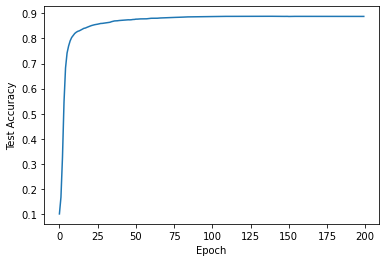

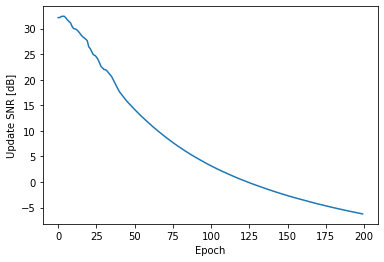

In [18]:
train_acc_history = np.load(PATH_ACC+'.npy')
plt.plot(np.arange(epoch_max), train_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.show()

update_rho_history = np.load(PATH_RHO+'.npy')
plt.plot(np.arange(epoch_max), 10*np.log10(update_rho_history/noise_pow))
plt.xlabel('Epoch')
plt.ylabel('Update SNR [dB]')
plt.show()

In [19]:
net = Net()
net.load_state_dict(torch.load(PATH_NET))
outputs = net(images.cpu())

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100.0 * correct / total))

Accuracy of the network on the 10000 test images: 88.77 %


In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %d : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 96.12 %
Accuracy of 1 : 98.24 %
Accuracy of 2 : 91.67 %
Accuracy of 3 : 89.60 %
Accuracy of 4 : 93.69 %
Accuracy of 5 : 80.61 %
Accuracy of 6 : 85.28 %
Accuracy of 7 : 85.31 %
Accuracy of 8 : 82.44 %
Accuracy of 9 : 82.56 %


In [22]:
print('Number of total devices: ', dev_num)
print('Distance of device %d: '%(dev_num-1), dev_dist[dev_num-1])
print('Sub-channel activation ratio of device %d: '%(dev_num-1), np.sum(P_alloc>0)/B)
print('Remaining powers of device %d: '%(dev_num-1), P-np.sum(P_alloc))

Number of total devices:  25
Distance of device 24:  149.3684804164992
Sub-channel activation ratio of device 24:  0.0556640625
Remaining powers of device 24:  -56.00000146493786
